Filename type: train

process_type: all
process_type: all
Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_Teenager', 'Age_bin_Adult', 'Family_bin_SmallFamily', 'Family_bin_BigFamily', 'Family_bin_Team', 'Fare_bin_Median', 'Fare_bin_Average', 'Fare_bin_High', 'Mother', 'Father', 'Daughter', 'Son', 'Orphan', 'RichWoman', 'MiddleClassWoman', 'PoorWoman', 'RichMan', 'MiddleClassMan', 'PoorMan', 'RichGirl', 'MiddleClassGirl', 'PoorGirl', 'RichBoy', 'MiddleClassBoy', 'PoorBoy'], dtype='object') Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'PclassCp_2', 'PclassCp_3', 'Title_Mr0', 'Title_Mr50', 'Title_Mrs', 'Title_Ms', 'FamilySize', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_X', 'Age_bin_Kid', 'Age_bin_

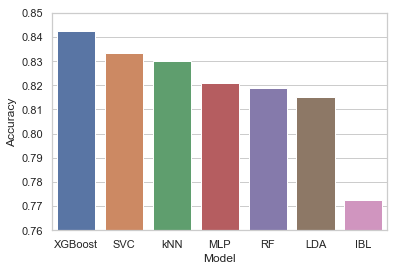

In [21]:
##
#from MyPreprocessing import MyPreprocessing
import pandas as pd
import numpy as np
from config_loader import load
import argparse
import sys
import seaborn as sns
from MyDataUnderstanding import featureAnalysis
from MyPreprocessing import MyPreprocessing
from MyFeatureSelection import MyFeatureSelection


import numpy as np
from time import time
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
from model.models import models_perform
from sklearn.model_selection import KFold
import xgboost as xg
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
sns.set(style="whitegrid")


def getData(path, filenames_type):
    '''
    features_lst = [
        "Pclass", "Survived", "Name", "Sex", "Age",
        "Sibsp", "Parch", "Ticket", "Fare", "Cabin","Embarked"]
    '''
    if filenames_type == 'train':
        filename = 'train'
    elif filenames_type == 'test':
        filename = 'test'
    else:
        filename = 'titanicAll'
    df_features = pd.read_csv(path + filename + '.csv',
                           sep=',')

    if filenames_type not in ['train', 'test']:
        # drop unnecessary columns that don't exist in the official dataset
        df_features.drop(['Boat', 'Body', 'Home.dest'],
                          axis=1,
                         inplace=True)
    #labels = df_features['Survived']
    #df_features = df_features.drop(['Survived'], axis=1)
    return df_features
##
if __name__ == '__main__':
    ##
    # Loads config
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "-c", "--config", default="titanic.cfg",
        help="specify the location of the clustering config file"
    )
    args, _ = parser.parse_known_args()

    config_file = args.config
    config = load(config_file)

    ##
    verbose = config.get('titanic', 'verbose')
    path = config.get('titanic', 'path') + '/'
    file_type = config.get('titanic', 'file_type')

    filename_type = 'train'
    if file_type == 'all':
        filename_type = 'other'

    print('Filename type:', filename_type)
    print()
    ## train
    trainData = getData(path, filename_type)
    # Preprocessing
    trainPreprocess = MyPreprocessing(process_type='all',
                                      filename_type=filename_type,
                                      remove_outliers=True)

    ## test
    filename_type = 'test'
    testData = getData(path, filename_type)
    # Preprocessing
    testPreprocess = MyPreprocessing(process_type='all',
                                     filename_type=filename_type,
                                     remove_outliers=False)

    ## Data Understanding
    if verbose == 'true':
        featureAnalysis(trainData)
        featureAnalysis(testData)


    trainPreprocess.fit(trainData)
    df_train = trainPreprocess.new_df
    # the labels "Survived"
    labels = trainPreprocess.labels_
    #print(labels.head())
    # the initial dataset without any preprocessing
    #print(trainPreprocess.df_initial.head())
    # the preprocessed data
    #print(trainPreprocess.new_df.head())

    testPreprocess.fit(testData)
    df_test = testPreprocess.new_df

    # fix missing columns because of NaNs and one hot encoding without dummy_na
    if df_train.shape[1] != df_test.shape[1]:
        missing_cols = set(df_test.columns) - set(df_train.columns)
        for col in missing_cols:
            #df_train[col] = np.zeros([df_train.shape[0], 1])
            df_test.drop([col], axis=1, inplace=True)

        missing_cols = set(df_train.columns) - set(df_test.columns)
        for col in missing_cols:
            #df_test[col] = np.zeros([df_test.shape[0], 1])
            df_train.drop([col], axis=1, inplace=True)

    labels_test = testPreprocess.labels_

    print(df_train.columns, df_test.columns)
    print(df_train.shape, df_test.shape)

    '''
    Best Feature Selection technique for each model:
                                        Accuracy    Time
    ALL_49_XGBClassifier					0.822198	0.148959
    ALL_49_SVC								0.821009	0.036744
    ICA_d_25/49RandomForestClassifier		0.817587	0.023186
    ALL_49_LinearDiscriminantAnalysis		0.814099	0.018538
    ALL_49_KNeighborsClassifier				0.807196	0.014191
    PCA_d_20/49_ev_0.932_MLPClassifier		0.807176	3.611699
    RF_d_25/49MyIBL							0.778340	2.562606
    '''

    #warnings.filterwarnings("ignore")
    
    '''ASIERdef xgBoost(data, labels, train_fidx, validation_fidx):
        model = xg.XGBClassifier()
        folds_accuracy = list()
        for idx, trf in enumerate(train_fidx):
            model.fit(data.loc[trf], labels.loc[trf])
            prediction_labels = model.predict(data.loc[validation_fidx[idx]])

            folds_accuracy.append(accuracy_score(labels.loc[validation_fidx[idx]], prediction_labels))
        print("Support Vector Classifier provided", mean(folds_accuracy), "accuracy at validation stage.")
    
    # Divide dataset in folds
    kf = KFold(n_splits=5)

    folds = [(train_idx, validation_idx) for train_idx, validation_idx in kf.split(df_train)]
    train_idx = [f[0] for f in folds]
    validation_idx = [f[1] for f in folds]
    
    xgBoost(df_train, labels, train_idx, validation_idx)'''
    
    # XGBoost
    # Best params:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 350, 'objective': 'binary:logistic', 'subsample': 0.5}
    # Best score:  0.8536036036036037
    '''configs = [
        {'objective':'binary:logistic', 'n_estimators':500, 'max_depth':5, 'learning_rate':0.01, 'gamma':0, 'subsample':0.50, 'colsample_bytree':0.6},
        {'objective':'binary:logistic', 'n_estimators':500, 'max_depth':5, 'learning_rate':0.01, 'gamma':0, 'subsample':0.50, 'colsample_bytree':0.6}
    ]

    param_ranges = {
        'objective' : ['binary:logistic', 'binary:hinge'],
        'n_estimators' : [150, 200, 250, 300, 350, 400, 450, 500],
        'max_depth' : [4, 5, 6, 7],
        'learning_rate' : [0.1, 0.01, 0.001, 0.0001],
        'subsample' : [0.5, 0.6],
        'colsample_bytree' : [0.5, 0.6]
    }

    xgb = xg.XGBClassifier()

    grid_search = GridSearchCV(xgb, param_ranges, cv=5, scoring="accuracy", n_jobs=4, verbose=2)

    grid_search.fit(df_train, labels)
    
    print("Best params: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    
    # Random Forest
    # Best params:  {'criterion': 'gini', 'max_depth': 90, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200}
    # Best score:  0.831081081081081
    param_ranges = {
        'criterion' : ['gini', 'entropy'],
        'n_estimators' : [50, 100, 150, 200],
        'max_features' : ['auto', 'sqrt', 'log2'],
        'max_depth' : [80, 90, 100, 110],
        'min_samples_leaf' : [3, 4, 5, 6, 7, 8],
        'min_samples_split' : [6, 8, 10, 12],
    }
    
    # ICA - 20 dimensions - for feeding Random Forest Classifier
    n_dim_ICA = 20
    ica_train, ica_test = MyFeatureSelection.applyICA(df_train, df_test, n_dim_ICA)

    rf = RandomForestClassifier()

    grid_search = GridSearchCV(rf, param_ranges, cv=5, scoring="accuracy", n_jobs=4, verbose=2)

    grid_search.fit(ica_train, labels)
    
    print("Best params: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    
    # MLP
    # Best params:  {'activation': 'tanh', 'hidden_layer_sizes': 14, 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}
    # Best score:  0.838963963963964
    param_ranges = {
        'activation' : ['tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init' : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        'hidden_layer_sizes' : [9, 10, 11, 12, 13, 14, 15]
    }
    
    # PCA - 17 dimensions - for feeding MLP
    n_dim_PCA = 17
    pca_train, pca_test, ev = MyFeatureSelection.applyPCA(df_train, df_test, n_dim_PCA)

    mlp = MLPClassifier()

    grid_search = GridSearchCV(mlp, param_ranges, cv=5, scoring="accuracy", n_jobs=4, verbose=2)

    grid_search.fit(pca_train, labels)
    
    print("Best params: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    
    # SVC
    # Best params:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
    # Best score:  0.829954954954955
    param_ranges = {
        'C' : [1, 10, 100],
        'kernel' : ['linear', 'rbf', 'sigmoid'],
        'gamma' : ['auto', 0.001, 0.01, 0.1, 1],
    }

    svc = SVC()

    grid_search = GridSearchCV(svc, param_ranges, cv=5, scoring="accuracy", n_jobs=4, verbose=2)

    grid_search.fit(df_train, labels)
    
    print("Best params: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    
    
    # kNN
    # Best params:  {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
    # Best score:  0.831081081081081
    param_ranges = {
        'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29],
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric' : ['euclidean', 'manhattan'],
        'weights' : ['uniform', 'distance']
    }

    knn = KNeighborsClassifier()

    grid_search = GridSearchCV(knn, param_ranges, cv=5, scoring="accuracy", n_jobs=4, verbose=2)

    grid_search.fit(df_train, labels)
    
    print("Best params: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)'''
    
    tips = sns.load_dataset("tips")
    
    df = {'Model' : ['XGBoost', 'SVC', 'kNN', 'MLP', 'RF', 'LDA', 'IBL'],
          'Accuracy' : [0.8423, 0.83322, 0.8299, 0.8209, 0.8187, 0.8153, 0.7725]}
    ax = sns.barplot(x="Model", y="Accuracy", data=pd.DataFrame(df))
    ax.set(ylim=(0.76, 0.85))
